In [1]:
# from statistics import median
import pickle

import matplotlib.pyplot as plt
import numpy as np

import tomography.global_constants as glob
import tomography.operators as op
import tomography.tomography_helper_functions as helper
from helpers.coeff_groups_class import CoefficientGroups
from tomography.plot_dm import plot_complex_density_matrix
from tomography.temporal_average import temporal_average

plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY

# Importing Data
Rearranged folders (from Donny's usual format) so that both P1 and P2 files are in the same folder. This way I don't have to deal with separate "P1" and "P2" folders.

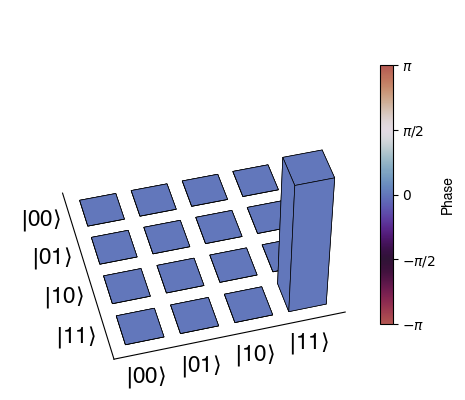

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

In [2]:
state_name = "0001_ns1_53"
NO_IDENTITY = False

if NO_IDENTITY:
    rho_theory = op.RHO_0001
else:
    rho_theory = op.CLEAN_0001
plot_complex_density_matrix(rho_theory)
display(rho_theory)

In [3]:
data_folder = fr"C:\Users\lemon\OneDrive - Brown University\CNOT project\MIT\data\2025_02_19\{state_name}"

# Calculating the frequency axis for the spectrum
All data in below cell is from Donny's email & Bruker plots

According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

In [4]:
# freqs, all_spectra_complex = temporal_average(data_folder, AQ=2.2, PHASE_0=0, remove_digital=True,
#                                               auto_phase=True, phase_width=150, state_name="0001")
PH_0 = -145.696 + 90

freqs, all_spectra_complex = temporal_average(data_folder, AQ=2.2, PHASE_0=PH_0, remove_digital=True)

C:\Users\lemon\AppData\Local\pypoetry\Cache\virtualenvs\cnot-4ROsunUI-py3.11\Lib\site-packages\nmrglue\fileio\bruker.py:394: UserWarning: Error reading the pulse program
  warn('Error reading the pulse program')


In [5]:
# DIFFERENT FOR THIS MEASUREMENT!
SPECTRUM_WIDTH = 2000  # Hz

freqs_local = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, all_spectra_complex.shape[1])

# assert np.array_equal(freqs, freqs_local)

B_0 = 14.0921  # Tesla
J = 21.97  # Hz (Based on Donny's text)
L_FREQ = -J / 2
R_FREQ = J / 2

# probably won't need...?
SPECTRUM_OFFSET = 49697.66
w_1_Bruker = 202474441.0  # Hz
w_2_Bruker = 202475194.8  # Hz
TEMP = 310  # Kelvin

# Plotting Everything Together

In [6]:
all_spectra = np.zeros((all_spectra_complex.shape[0] * 2, all_spectra_complex.shape[1]))

for i in range(all_spectra_complex.shape[0]):
    all_spectra[i * 2, :] = all_spectra_complex[i, :].real
    all_spectra[i * 2 + 1, :] = all_spectra_complex[i, :].imag

all_spectra.shape

(28, 4410)

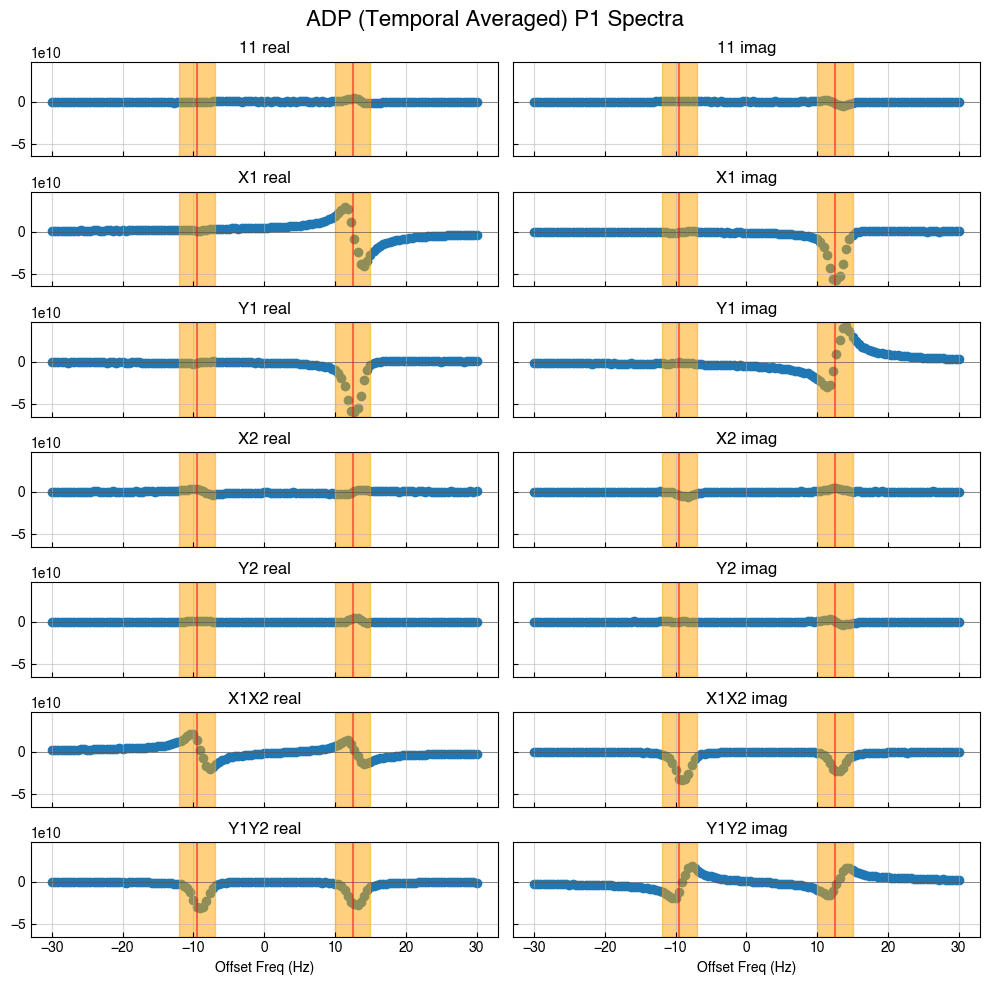

In [7]:
INT_WIDTH = 5  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-30, 30]

# Making an offset so the red lines visually line up with the peaks
p1_offset = 1.5
p1_freqs = (L_FREQ + p1_offset, R_FREQ + p1_offset)

fig_1, axs_1 = helper.plot_spectra_together(freqs, all_spectra[:all_spectra.shape[0] // 2],
                                            glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p1_freqs[0], p1_freqs[1],
                                            int_width=INT_WIDTH, share_y=True)
fig_1.suptitle('ADP (Temporal Averaged) P1 Spectra', size=16)
fig_1.tight_layout()
plt.show()

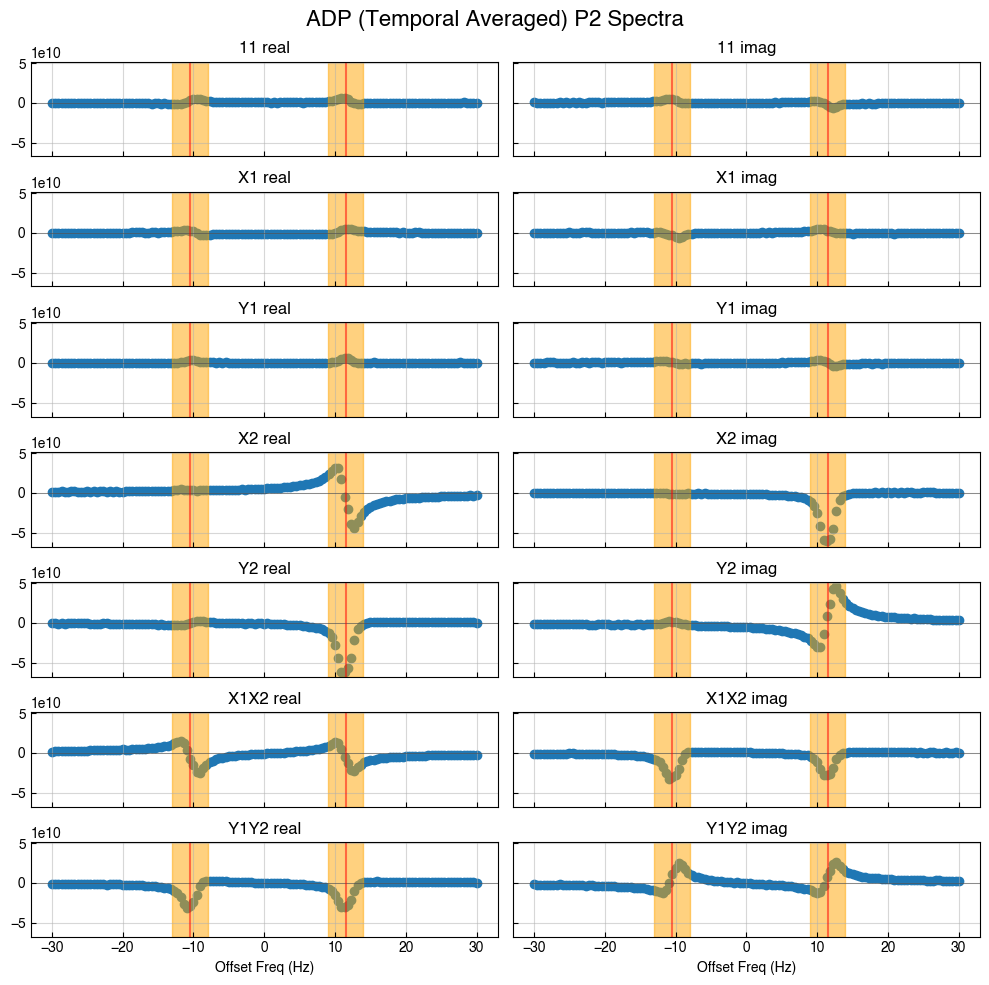

In [8]:
# Making an offset so the red lines visually line up with the peaks
p2_offset = .5
p2_freqs = (L_FREQ + p2_offset, R_FREQ + p2_offset)

fig_2, axs_2 = helper.plot_spectra_together(freqs, all_spectra[all_spectra.shape[0] // 2:], glob.SPECTRA_NAMES,
                                            X_LIMS_DISPLAY, p2_freqs[0], p2_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_2.suptitle('ADP (Temporal Averaged) P2 Spectra', size=16)
fig_2.tight_layout()
plt.show()

# Preparing for Tomography Calculations:

We use convention of using the "I" to denote the first spin ($I_1$) and "S" the second spin ($I_2$)

$(I=I_1, S=I_2)$

Quick Check that our pulse sequences covers all 15 basis operators (not necessary)

In [9]:
op.check_basis_complete()

Operator basis is complete (15 elements)


# Three Methods for calculating coefficients

1. Just the height of the spectrum at the expected peak locations
2. Integration of peaks (simpson method & trapezoid method, but both seem to give almost identical answers)
3. (no longer used) Fitting a theoretical Lorentzian model to our data using scipy.curve_fit

## First approach: get height of one data point closest to theoretical peak locations

### Construct a "`coefficient groups`". 
"coefficient groups" is a list of "group"s, with each group being a list of:

`[operator, (c1, spectrum type), (c2, spectrum type), (c3, spectrum type), ...]`

where the first element of the group is a product operator,

and the following elements are tuples of: (coefficients corresponding to that operator, the type of spectrum which the coefficient came from).

In the case of ADP there are two spectrum types: P1 and P2

(each spectrum produces two coefficients)

In [10]:
coeff_groups_height = CoefficientGroups()

for (i, spectrum) in enumerate(all_spectra):
    # Height of the point closest to each peak's frequency location
    L = spectrum[np.absolute(freqs - L_FREQ).argmin()]
    R = spectrum[np.absolute(freqs - R_FREQ).argmin()]
    coeff_groups_height.add_coefficient(op.product_operators[i][0], L + R, helper.index_to_element(i))
    coeff_groups_height.add_coefficient(op.product_operators[i][1], L - R, helper.index_to_element(i))
    # print(f"Spectrum {thermal_col_names[i]} L+R is: {(L+R):.1e}, L-R is {(L-R):.1e}")

print(f'number of groups is: {len(coeff_groups_height.data)} (<- should be 15)')

number of groups is: 15 (<- should be 15)


Average the coefficients for each operator, and reconstruct the density matrix

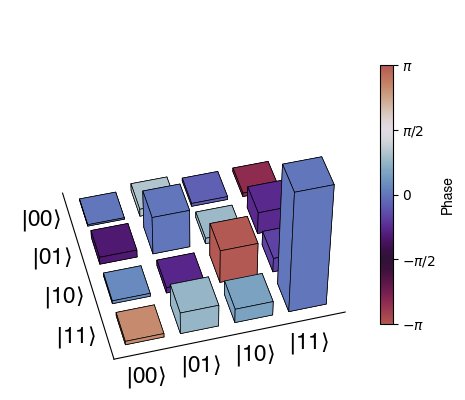

projection: (0.8821590308263663+0j)


In [11]:
rho_height = coeff_groups_height.reconstruct_rho(abs_trace=True)
plot_complex_density_matrix(rho_height)
print(f"projection: {helper.projection_fortunato(rho_height, rho_theory)}")

## Second Approach: integrate the raw data
1. Integrate sample points using (`scipy.integrate.trapezoid`)
2. Integrate sample points using (`scipy.integrate.simpson`)

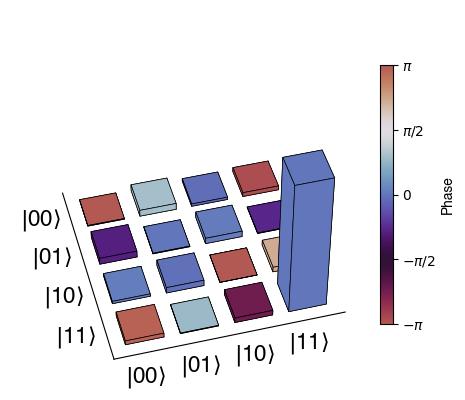

projection of naive integration: (0.9928031883483188+0j)


In [12]:
rho_naive = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, INT_WIDTH)

plot_complex_density_matrix(rho_naive)
print(f"projection of naive integration: {helper.projection_fortunato(rho_naive, rho_theory)}")

### Integrating with various different parameters to find the integration with the largest projection value:

In [13]:
if not NO_IDENTITY:
    result_filename = f"result_{state_name}.pickle"
    error_filename = f"result_{state_name}_error.pickle"
else:
    result_filename = f"result_{state_name}_no_1.pickle"
    error_filename = f"result_{state_name}_no_1_error.pickle"

# Looking for result pickle file. If not found, optimize integration then save the results (& the error matrix)
try:
    with open(result_filename, "rb") as result_file:
        best_rho_simpson, best_projection, best_params = pickle.load(result_file)
        best_offsets, best_int_width, best_j_offset = best_params["offsets"], best_params["width"], best_params[
            "j_offset"]
    print("Found previously saved result file!")

except FileNotFoundError:
    print("Couldn't find saved result. Integrating and saving the result...")
    best_rho_simpson, best_projection, best_params, rho_error = \
        helper.integrate_optimized(freqs, all_spectra, p1_freqs, p2_freqs, rho_theory, return_error=True,
                                   j_offset_range=np.linspace(-1, 1, 11),
                                   add_identity=(not NO_IDENTITY), try_adding_neg=(not NO_IDENTITY))
    best_offsets, best_int_width, best_j_offset = best_params["offsets"], best_params["width"], best_params["j_offset"]
    with open(result_filename, "wb") as result_file:
        pickle.dump([best_rho_simpson, best_projection, best_params], result_file)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)

# Looking for error pickle file. If not found, calculate & save the error matrix
try:
    with open(error_filename, "rb") as error_file:
        rho_error = pickle.load(error_file)
    print("Found previously saved error file")

except FileNotFoundError:  # in the case where result file exists but error file doesn't.
    print("Couldn't find saved error file. Calculating and saving error")
    rho_error = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, best_int_width,
                                         best_offsets[0], best_offsets[1], return_error=True)
    with open(error_filename, "wb") as error_file:
        pickle.dump(rho_error, error_file)


Found previously saved result file!
Found previously saved error file


Best projection: 0.9951079028895196
Best parameters: {'offsets': (0.20000000000000018, -0.5), 'width': 3, 'j_offset': 0.6000000000000001}
p_init_offsets: (1.5, 0.5)


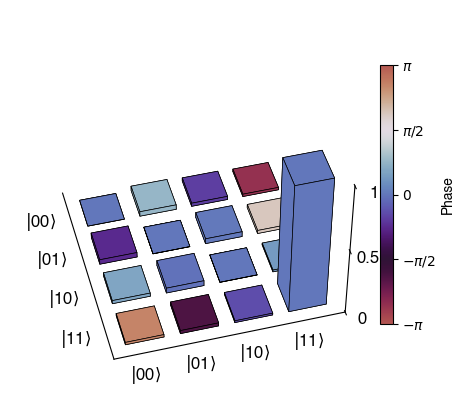

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

In [14]:
print(f"Best projection: {best_projection}")
print(f"Best parameters: {best_params}")
print(f"p_init_offsets: {p1_offset, p2_offset}")
plot_complex_density_matrix(best_rho_simpson, label_size=12, label_qubit=True, save_to="", hide_z_axis=False)

In [15]:
display(best_rho_simpson)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00+0.j          2.55879385e-02+0.02651538j
   2.20004974e-02-0.01394328j -1.76203910e-02-0.00886729j]
 [ 2.55879385e-02-0.02651538j  8.15448794e-04+0.j
   4.03183567e-02+0.00108946j -1.01820294e-02+0.02314532j]
 [ 2.20004974e-02+0.01394328j  4.03183567e-02-0.00108946j
   1.06952359e-03+0.j          1.34088130e-02+0.00612219j]
 [-1.76203910e-02+0.00886729j -1.01820294e-02-0.02314532j
   1.34088130e-02-0.00612219j  9.98115028e-01+0.j        ]]

In [16]:
print(best_rho_simpson)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00+0.j          2.55879385e-02+0.02651538j
   2.20004974e-02-0.01394328j -1.76203910e-02-0.00886729j]
 [ 2.55879385e-02-0.02651538j  8.15448794e-04+0.j
   4.03183567e-02+0.00108946j -1.01820294e-02+0.02314532j]
 [ 2.20004974e-02+0.01394328j  4.03183567e-02-0.00108946j
   1.06952359e-03+0.j          1.34088130e-02+0.00612219j]
 [-1.76203910e-02+0.00886729j -1.01820294e-02-0.02314532j
   1.34088130e-02-0.00612219j  9.98115028e-01+0.j        ]]


In [17]:
rho_non_neg = best_rho_simpson - op.IDENTITY * np.min(best_rho_simpson.diag())

In [18]:
helper.projection_fortunato(rho_non_neg, op.CLEAN_1000)

0j

In [19]:
(rho_theory.sqrtm() * best_rho_simpson * rho_theory.sqrtm()).sqrtm() ** 2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.99811503]]